In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re

# Importing required libraries
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

In [23]:
#Validation set manually annotated 
Validationdata = pd.read_csv('data/ds.tsv',delimiter="\t")

#Set of posts samples (positive/control) filtered by their topical similarity with a depression taxonomy (Ht)
HT_data = pd.read_csv('data/ts_ht.tsv',delimiter="\t")

# Set of posts samples (positive/control) filtered by their sentiment polarity score (Hs)
HS_data = pd.read_csv('data/ts_hs.tsv',delimiter="\t")

In [24]:

X_train = HT_data['pp_text']
X_test = Validationdata['pp_text']
y_train = HT_data['label']
y_test = Validationdata['label']
y_test

0      1
1      1
2      1
3      1
4      1
      ..
143    0
144    0
145    0
146    0
147    0
Name: label, Length: 148, dtype: int64

In [25]:
# defining function to clean text and retrive closs-validation datasets
def cleantxt(txt):
    """
    Cleans the string passed. Cleaning Includes-
    1. remove special characters/symbols
    2. convert text to lower-case
    3. retain only alphabets
    4. remove words less than 3 characters
    5. remove stop-words
    """  
    # collecting english stop words from nltk-library
    stpw = stopwords.words('english')
    
    # Adding custom stop-words
    stpw.extend(['www','http','utc'])
    stpw = set(stpw)
    
    # using regex to clean the text
    txt = re.sub("[\<\[].*?[\>\]]", " ", txt)
    txt = txt.lower()
    txt = re.sub(r"[^a-z ]", " ", txt)
    txt = " ".join([x for x in txt.split() if x not in stpw])
    return txt




In [26]:

for text in X_train:
    cleantxt(text)
    
for text in X_test:
    cleantxt(text)

In [27]:
max_features = 100000
batch_size = 128
epochs = 5
num_classes=5
embed_size = 128
num_unique_word = 6948

In [28]:
   
tokenizer = Tokenizer(num_words=num_unique_word)

tokenizer.fit_on_texts(X_train)
list_tokenized_train = tokenizer.texts_to_sequences(X_train)

tokenizer.fit_on_texts(X_test)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)



X_t = pad_sequences(list_tokenized_train, 150)
X_test = pad_sequences(list_tokenized_test, 150)



X_val = X_t[:3000]
X_trainn = X_t[3000:]

y_val = y_train[:3000]
y_trainn = y_train[3000:]

y_trainn = np.asarray(y_trainn)
y_val = np.asarray(y_val)

print('Shape of X train and X validation tensor:', X_trainn.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_trainn.shape,y_val.shape)

Shape of X train and X validation tensor: (4000, 150) (3000, 150)
Shape of label train and validation tensor: (4000,) (3000,)


In [8]:
word_vectors = dict()

# load the whole embedding into memory
f = open('glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 1193515 word vectors.


In [9]:

vocabulary_size = 6948 



In [10]:
embedding_matrix = np.zeros((num_unique_word, 200))
for word, index in tokenizer.word_index.items():
    if index > num_unique_word - 1:
        break
    else:
        embedding_vector = word_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [11]:
## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 200, input_length=150, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [12]:

hist = model_glove.fit(X_trainn,y_trainn, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/5
32/32 [==============================] - 4s 90ms/step - loss: 0.6181 - accuracy: 0.6549 - val_loss: 0.5521 - val_accuracy: 0.7390
Epoch 2/5
32/32 [==============================] - 2s 60ms/step - loss: 0.5056 - accuracy: 0.7585 - val_loss: 0.5413 - val_accuracy: 0.7303
Epoch 3/5
32/32 [==============================] - 2s 60ms/step - loss: 0.4990 - accuracy: 0.7651 - val_loss: 0.5090 - val_accuracy: 0.7590
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.4701 - accuracy: 0.7821 - val_loss: 0.4937 - val_accuracy: 0.7697
Epoch 5/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4279 - accuracy: 0.8077 - val_loss: 0.5221 - val_accuracy: 0.7603


In [13]:
results = model_glove.evaluate(X_test,Validationdata['label'])

5/5 [==============================] - 0s 5ms/step - loss: 0.5537 - accuracy: 0.7500


In [29]:

predictedsvm = model_glove.predict_classes(X_test)
predictedsvm = predictedsvm[:, 0]
accuracy_score_sig = metrics.accuracy_score(predictedsvm, y_test)
accuracy_score_auc = metrics.roc_auc_score(predictedsvm, y_test)
accuracy_score_priv = metrics.precision_score(predictedsvm, y_test)
accuracy_score_recall = metrics.recall_score(predictedsvm, y_test)

print(accuracy_score_priv)
print(accuracy_score_recall)
print(accuracy_score_auc)
accuracy_score_sig

C:\Users\calum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9272727272727272
0.6071428571428571
0.7723214285714286


0.75

In [14]:
## create model
model2 = Sequential()
model2.add(Embedding(vocabulary_size, 200, input_length=160, weights=[embedding_matrix], trainable=False))
model2.add(Dropout(0.2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=4))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [15]:
hist2 = model2.fit(X_trainn,y_trainn, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/5
32/32 [==============================] - 2s 43ms/step - loss: 0.6584 - accuracy: 0.6037 - val_loss: 0.6405 - val_accuracy: 0.6499
Epoch 2/5
32/32 [==============================] - 1s 38ms/step - loss: 0.6357 - accuracy: 0.6452 - val_loss: 0.6333 - val_accuracy: 0.6508
Epoch 3/5
32/32 [==============================] - 1s 38ms/step - loss: 0.6239 - accuracy: 0.6516 - val_loss: 0.6289 - val_accuracy: 0.6515
Epoch 4/5
32/32 [==============================] - 1s 38ms/step - loss: 0.6191 - accuracy: 0.6592 - val_loss: 0.6315 - val_accuracy: 0.6509
Epoch 5/5
32/32 [==============================] - 1s 38ms/step - loss: 0.6131 - accuracy: 0.6649 - val_loss: 0.6272 - val_accuracy: 0.6516


In [16]:
model2 = model2.evaluate(X_test,Validationdata['label'])

5/5 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.7205


In [20]:

predictedsvm = model2.predict_classes(X_test)
predictedsvm = predictedsvm[:, 0]
accuracy_score_sig = metrics.accuracy_score(predictedsvm, y_test)
accuracy_score_auc = metrics.roc_auc_score(predictedsvm, y_test)
accuracy_score_priv = metrics.precision_score(predictedsvm, y_test)
accuracy_score_recall = metrics.recall_score(predictedsvm, y_test)

print(accuracy_score_priv)
print(accuracy_score_recall)
print(accuracy_score_auc)
accuracy_score_sig

AttributeError: 'list' object has no attribute 'predict_classes'

In [17]:


## create model
model_glove3 = Sequential()
model_glove3.add(Embedding(vocabulary_size, 200, input_length=150, weights=[embedding_matrix], trainable=False))
model_glove3.add(Dropout(0.2))
model_glove3.add(Conv1D(64, 5, activation='relu'))
model_glove3.add(MaxPooling1D(pool_size=4))
model_glove3.add(LSTM(100))
model_glove3.add(Dense(1, activation='relu'))
model_glove3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
hist2 = model_glove3.fit(X_trainn,y_trainn, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/5
32/32 [==============================] - 4s 73ms/step - loss: 2.2200 - accuracy: 0.6410 - val_loss: 0.9028 - val_accuracy: 0.5093
Epoch 2/5
32/32 [==============================] - 2s 62ms/step - loss: 0.6512 - accuracy: 0.6579 - val_loss: 0.5770 - val_accuracy: 0.7237
Epoch 3/5
32/32 [==============================] - 2s 64ms/step - loss: 0.5412 - accuracy: 0.7303 - val_loss: 0.5555 - val_accuracy: 0.7273
Epoch 4/5
32/32 [==============================] - 2s 64ms/step - loss: 0.5222 - accuracy: 0.7505 - val_loss: 0.5587 - val_accuracy: 0.7397
Epoch 5/5
32/32 [==============================] - 2s 64ms/step - loss: 0.4960 - accuracy: 0.7754 - val_loss: 0.5540 - val_accuracy: 0.7453


In [18]:
results = model_glove3.evaluate(X_test,Validationdata['label'])

5/5 [==============================] - 0s 5ms/step - loss: 0.4367 - accuracy: 0.8311


In [19]:

predictedsvm = model_glove3.predict_classes(X_test)
predictedsvm = predictedsvm[:, 0]
accuracy_score_sig = metrics.accuracy_score(predictedsvm, y_test)
accuracy_score_auc = metrics.roc_auc_score(predictedsvm, y_test)
accuracy_score_priv = metrics.precision_score(predictedsvm, y_test)
accuracy_score_recall = metrics.recall_score(predictedsvm, y_test)

print(accuracy_score_priv)
print(accuracy_score_recall)
print(accuracy_score_auc)
accuracy_score_sig

C:\Users\calum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8909090909090909
0.7205882352941176
0.8227941176470589


0.831081081081081

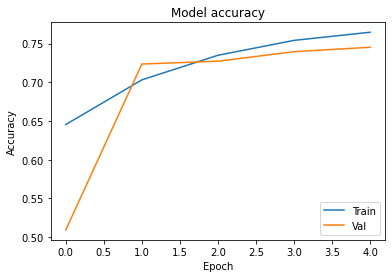

In [30]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

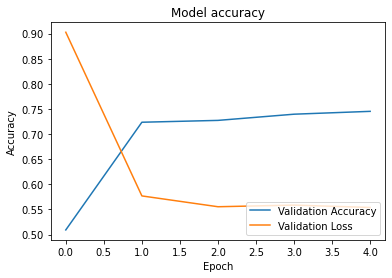

In [43]:
plt.plot(hist2.history['val_accuracy'])
plt.plot(hist2.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation Accuracy', 'Validation Loss'], loc='lower right')
plt.show()

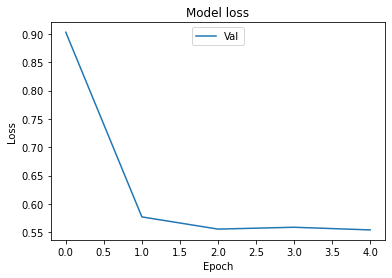

In [42]:

plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Val'], loc='upper center')
plt.show()

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

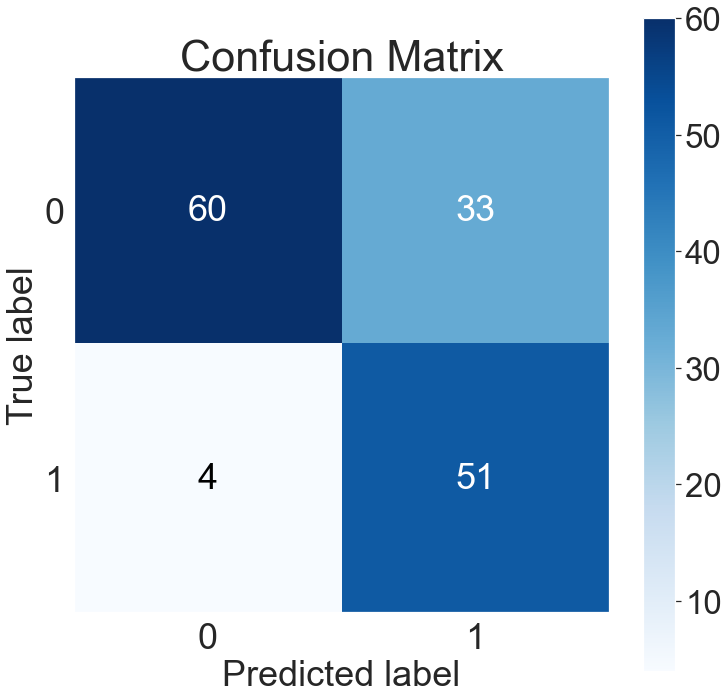

In [45]:
import scikitplot as skplt
import seaborn as sns

sns.set(font_scale=3.0)
skplt.metrics.plot_confusion_matrix(
    y_test, 
    predictedsvm,
    figsize=(12,12))